In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from models import Classifier, Metrics, find_threshold,DataSet, WeightedMSE, FlatLoss

In [2]:
files = np.load("data/W_FCN_v0.npz")
train = files["train"].astype('float32')
val = files["val"].astype('float32')

maxdata = train.max(axis=0)
mindata = train.min(axis=0)
train = (train-mindata)/(maxdata-mindata)
maxdata = val.max(axis=0)
mindata = val.min(axis=0)
val = (val-mindata)/(maxdata-mindata)

In [3]:
norm = lambda x: 2*(x-x.min())/(x.max()-x.min()) - 1
traindataset = DataSet(samples=train[::,1:-1],
                       labels=train[::,-1].astype('int32'),
                       m=norm(train[::,0]))
valdataset = DataSet(samples=val[:,1:-1],
                     labels=val[:,-1].astype('int32'),
                     m=norm(val[::,0]))

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda:0" if use_cuda else "cpu")
print('device:', device)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)

device: cpu


In [ ]:
frac=0.93
print("strength",frac/(1-frac))
params = {'epochs'     : 400,
          'interval'   : 50,
          'batch_size' : len(traindataset),
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':True,
          'loss'         : FlatLoss(frac=frac,labels=train[::,0],bins=100,
                                   background_only=False,norm='L2',recalculate=False),
         }

torch.manual_seed(69)
model_L   = Classifier().to(device)
optimizer = torch.optim.SGD(model_L.parameters(),lr=1e-1,momentum=0.)
model_L.fit(traindataset=traindataset,
            valdataset=valdataset,
            **params)

strength 13.285714285714295
Entering Training...
Epoch:0050/0400 || Train: loss:0.0397, acc:30% || Test: loss: 0.0492, acc:80%, R50: 1.9765, 1/JSD: 28.7559  || 147.8s
Epoch:0100/0400 || Train: loss:0.0397, acc:31% || Test: loss: 0.0492, acc:80%, R50: 1.9794, 1/JSD: 28.5993  || 299.0s
Epoch:0150/0400 || Train: loss:0.0397, acc:31% || Test: loss: 0.0493, acc:80%, R50: 1.9826, 1/JSD: 28.4412  || 452.3s
Epoch:0200/0400 || Train: loss:0.0397, acc:31% || Test: loss: 0.0493, acc:80%, R50: 1.9865, 1/JSD: 28.2908  || 607.2s
Epoch:0250/0400 || Train: loss:0.0397, acc:31% || Test: loss: 0.0494, acc:80%, R50: 1.9899, 1/JSD: 28.0842  || 756.4s
Epoch:0300/0400 || Train: loss:0.0396, acc:31% || Test: loss: 0.0495, acc:80%, R50: 1.9926, 1/JSD: 27.9252  || 908.2s
Epoch:0350/0400 || Train: loss:0.0396, acc:31% || Test: loss: 0.0495, acc:80%, R50: 1.9963, 1/JSD: 27.7627  || 1059.0s


In [ ]:
test = files["test"]
maxdata = test.max(axis=0)
mindata = test.min(axis=0)
test = (test-mindata)/(maxdata-mindata)

1.9942090241843167 0.0393717993517841


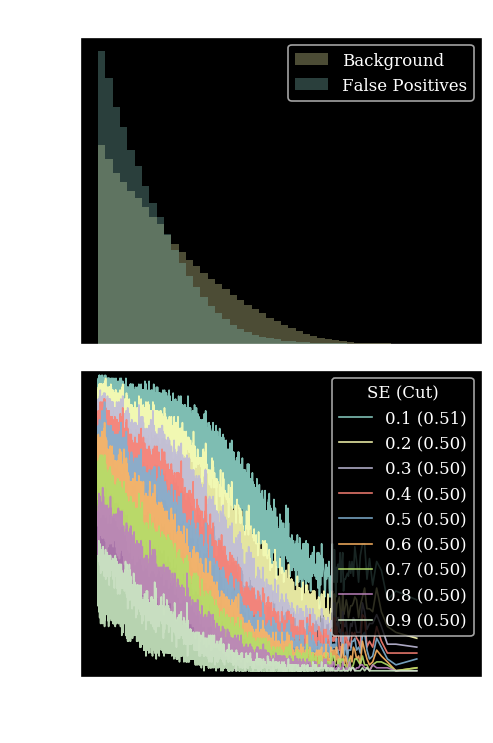

In [11]:
predictions = np.array(model_L(torch.Tensor(test[:,1:11]).float()).tolist()).flatten()
metrics_test = Metrics(validation=True)
metrics_test.calculate(pred=predictions, target=test[:,-1],m=test[:,0])
R50 = metrics_test.R50[0]
JSD = metrics_test.JSD[0]
print(R50,JSD)

def plot_test(predictions,R50,JSD,title='FlatLoss DNN'):
    c = find_threshold(predictions,(test[:,-1]==0),0.5)
    fig, [ax0,ax] = plt.subplots(2,1,figsize=(4,6),dpi=120,sharex=True)
    _,bins,_ = ax0.hist(test[:,0][(test[:,-1]==1)],bins=50,alpha=0.3,color='C1',label='Background',density=True)
    ax0.hist(test[:,0][(test[:,-1]==1)&(predictions<c)],bins=bins,alpha=0.3,color='C0',label='False Positives',density=True)
    ax0.set_ylabel("Normed Counts",fontsize=12)
    ax0.set_title('{} (R50:{:.2f}, 1/JSD:{:.2f})'.format(title,R50,1/JSD))
    ax0.legend()
    efficiencies = np.linspace(0.1,0.9,9)
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(predictions,(test[:,-1]==0),eff))
    m_t = test[:,0]
    sorted_m = np.argsort(m_t)
    scores = predictions[sorted_m].reshape(-1,100)
    m_t = m_t[sorted_m]
    m = m_t.reshape(-1,100).mean(axis=1)
    F_s = []
    for s in scores.reshape(50,-1):
        density = np.histogram(s,bins=50,range=(0,1))[0]
        F_s.append(np.cumsum(density)/density.sum())
    F_s = np.array(F_s).T
    for j,cut in enumerate(cuts):
        c = f"C{j}" #if j!= 6 else f"C11"
        passed = (scores<cut).sum(axis=1)/scores.shape[1]
        ax.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

    ax.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=12)
    ax.set_ylim([-0.02,1.02])
    #ax1.set_title("(strength: {:.02f}, acc: {:.02})".format(1, metrics_val_legendre.accs[-1]),fontsize=17)
    ax.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,title="SE (Cut)",ncol=1)
    ax.set_xlabel(r"$m$",fontsize=12)

    fig.tight_layout(pad=0,w_pad=0)
    return fig
fig = plot_test(predictions,R50,JSD,title='FlatLoss DNN')

# Naive Model 

In [7]:
params_ = {'epochs' : 400,
          'interval'   : 100,
          'batch_size' : 8192,
          'shuffle'    : True,
          'num_workers': 6,
          'pass_x_biased':False,
          'loss' : WeightedMSE(labels=traindataset.labels),
         }

torch.manual_seed(69)
model     = Classifier()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1,momentum=0.)
model.fit(traindataset=traindataset,
          valdataset=valdataset,
          **params_)

Epoch:0100/0400 || Train: loss:0.3459, acc:51% || Test: loss: 0.0489, acc:74%, R50: 4.0749, 1/JSD: 8.9122  || 94.1s
Epoch:0200/0400 || Train: loss:0.3456, acc:65% || Test: loss: 0.0488, acc:75%, R50: 5.9410, 1/JSD: 11.4472  || 197.2s
Epoch:0300/0400 || Train: loss:0.3456, acc:68% || Test: loss: 0.0488, acc:76%, R50: 7.4101, 1/JSD: 11.9224  || 292.3s
Epoch:0400/0400 || Train: loss:0.3448, acc:69% || Test: loss: 0.0488, acc:76%, R50: 8.3640, 1/JSD: 12.7044  || 390.6s


8.375391576749042 0.07226970807941181


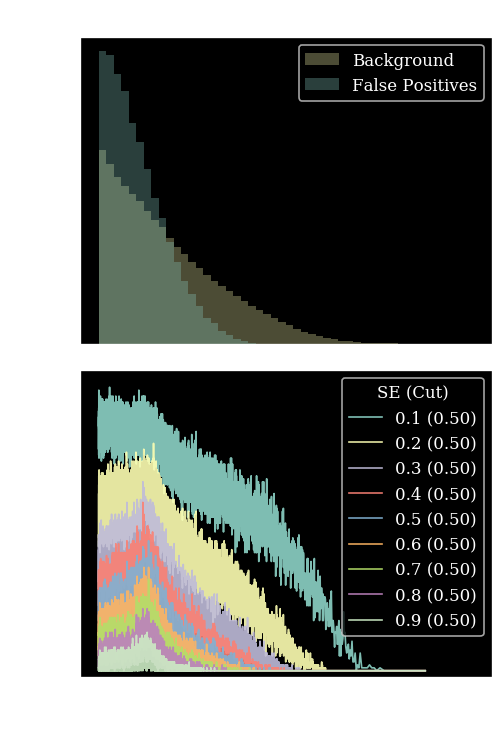

In [9]:
predictions = np.array(model(torch.Tensor(test[:,1:11]).float()).tolist()).flatten()
metrics_test = Metrics(validation=True)
metrics_test.calculate(pred=predictions, target=test[:,-1],m=test[:,0])
R50 = metrics_test.R50[0]
JSD = metrics_test.JSD[0]
print(R50,JSD)
fig = plot_test(predictions,R50,JSD,title='Naive DNN')

In [10]:
model.loss